In [1]:
import time
import logging
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.coordinates import Distance
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from utils import (
    get_source_identifier,
    insert_space_source_ids,
    convert_F_nu_to_luminosity,
)


log = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s|%(name)s|%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
)

In [2]:
catalog = Table.read('fr0_coreG_catalogue.fits', format='fits')

In [3]:
catalog['L_5Ghz'] = 3.57 * catalog['NVSS-FLUX-XMATCH']

In [4]:
catalog


SOURCE_NAME,SOURCE_TYPE,SIMBAD SDSS-ID,SIMBAD FERMI-ID,SIMBAD NVSS-ID,NVSS-XMATCH-ID,NVSS-MORX-ID,SIMBAD FIRST-ID,FIRST-XMATCH-ID,FIRST-MORX-ID,XMM-MORX-ID,CXO-MORX-ID,SWIFT-MORX-ID,LoTSS-MORX-ID,VLASS-MORX,LOBE EXTENSION,DISTANCE,Log10(L_OIII),TORESSI DETECTION,NVSS-FLUX-XMATCH,NVSS-FLUX-ERROR-XMATCH,FIRST-FLUX-XMATCH,FIRST-FLUX-ERROR-XMATCH,4XMM Mean Flux (2.0-4.5keV band),4XMM Mean Flux Error (2.0-4.5keV band),4XMM Mean Flux (4.5-12keV band),4XMM Mean Flux Error (4.5-12keV band),4XMM Mean Flux (0.2-12keV band),4XMM Mean Flux Error (0.2-12keV band),ACIS Flux F_b,F_b lowlim,F_b uplim,HRC Flux F_w,F_w lowlim,F_w uplim,Swift PowerLaw-Flux,Swift Flux Neg,Swift Flux Pos,Hardness Ratio 4-5,L_5Ghz
,,,,,,,,,,,,,,,mas,Mpc,erg / s,,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,,erg / s
bytes10,bytes9,bytes24,bytes17,bytes19,bytes19,bytes1,bytes22,bytes22,bytes21,bytes21,bytes21,bytes21,bytes22,bytes22,int16,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,FR0,SDSS J010852.48-003919.4,--,NVSS J010852-003922,NVSS J010852-003922,--,FIRST J010852.4-003919,FIRST J010852.4-003919,FIRSTJ010852.4-003919,--,--,--,--,VLAJ010852.48-003919.0,0,206.15471,39.77,False,7.617443993590242e+38,3.5595532680328238e+37,9.447054373359114e+38,9.753175564024665e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.719427505711716e+39
--,FR0,SDSS J011204.61-001442.4,--,NVSS J011204-001441,NVSS J011204-001441,--,FIRST J011204.6-001442,FIRST J011204.6-001442,FIRSTJ011204.6-001442,--,--,--,--,VLAJ011204.62-001442.1,0,201.42886,39.4,False,1.1961759114491608e+39,4.757517748607297e+37,1.2695776151062681e+39,7.204241199793214e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.270348003873504e+39
--,FR0,SDSS J011515.78+001248.4,--,NVSS J011515+001247,NVSS J011515+001247,--,FIRST J011515.7+001248,FIRST J011515.7+001248,FIRSTJ011515.7+001248,4XMM J011515.7+001248,CXOG J011515.7+001248,--,--,VLAJ011515.77+001248.7,0,206.15471,39.63,True,3.018501171291834e+39,9.254838157419886e+37,3.311808360577739e+39,7.759825937605555e+36,8.857541501411906e+40,6.508287195271214e+39,5.161097984842734e+40,1.4137731968450824e+40,4.176978122677506e+41,9.142458315137446e+39,2.3543902313097247e+41,2.196752959484764e+41,2.512027675423765e+41,0.0,0.0,0.0,0.0,0.0,0.0,-0.71128,1.0776049181511848e+40
NGC 707,FR0,SDSS J015127.10-083019.3,--,NVSS J015127-083019,NVSS J015127-083019,--,FIRST J015127.1-083019,FIRST J015127.1-083019,FIRSTJ015127.1-083019,--,--,--,--,VLAJ015127.11-083019.0,0,80.84892,39.32,False,4.007454241711921e+38,1.642399279390131e+37,3.539917913512196e+38,2.573092197851564e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4306611642911558e+39
--,FR0,SDSS J020835.81-083754.8,--,NVSS J020835-083755,NVSS J020835-083755,--,FIRST J020835.8-083755,FIRST J020835.8-083755,FIRSTJ020835.8-083755,--,--,--,--,VLAJ020835.82-083755.0,0,154.52747,39.73,False,1.1279750682804154e+39,3.5999203353168535e+37,1.0383770486723258e+39,5.759872441141641e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.026870993761083e+39
--,FR0,SDSS J075354.98+130916.5,--,NVSS J075355+130915,NVSS J075355+130915,--,FIRST J075354.9+130916,FIRST J075354.9+130916,FIRSTJ075354.9+130916,--,--,--,--,VLAJ075354.98+130916.6,0,220.37094,39.47,False,6.0197622384528654e+38,4.067406917873558e+37,1.026613506071286e+39,1.1307391115319044e+37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.1490551191276728e+39
--,FR0,SDSS J080716.58+145703.3,--,NVSS J080716+145703,NVSS J080716+145703,--,FIRST J080716.5+145703,FIRST J080716.5+145703,FIRSTJ080716.5+145703,--,--,--,--,VLAJ080716.56+145703.5,0,131.32161,39.13,False,8.926266228431127e+38,3.7553869486481945e+37,7.3663362079286e+38,4.073150684850659e+36,0.0,0.

## Cross-check X-ray measurements

In [5]:
fluxes_4xmm_nontherm = catalog["4XMM Mean Flux (4.5-12keV band)"] + catalog["4XMM Mean Flux (2.0-4.5keV band)"]

In [6]:
col = catalog['SIMBAD FERMI-ID']

# Convert masked entries to empty strings
clean_col = col.filled("")
fermi_sources = clean_col != ""

In [7]:
print(fermi_sources.sum())   # number of sources with FERMI IDs
catalog[fermi_sources]       # subset with only those sources

5


SOURCE_NAME,SOURCE_TYPE,SIMBAD SDSS-ID,SIMBAD FERMI-ID,SIMBAD NVSS-ID,NVSS-XMATCH-ID,NVSS-MORX-ID,SIMBAD FIRST-ID,FIRST-XMATCH-ID,FIRST-MORX-ID,XMM-MORX-ID,CXO-MORX-ID,SWIFT-MORX-ID,LoTSS-MORX-ID,VLASS-MORX,LOBE EXTENSION,DISTANCE,Log10(L_OIII),TORESSI DETECTION,NVSS-FLUX-XMATCH,NVSS-FLUX-ERROR-XMATCH,FIRST-FLUX-XMATCH,FIRST-FLUX-ERROR-XMATCH,4XMM Mean Flux (2.0-4.5keV band),4XMM Mean Flux Error (2.0-4.5keV band),4XMM Mean Flux (4.5-12keV band),4XMM Mean Flux Error (4.5-12keV band),4XMM Mean Flux (0.2-12keV band),4XMM Mean Flux Error (0.2-12keV band),ACIS Flux F_b,F_b lowlim,F_b uplim,HRC Flux F_w,F_w lowlim,F_w uplim,Swift PowerLaw-Flux,Swift Flux Neg,Swift Flux Pos,Hardness Ratio 4-5,L_5Ghz
,,,,,,,,,,,,,,,mas,Mpc,erg / s,,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,erg / s,,erg / s
bytes10,bytes9,bytes24,bytes17,bytes19,bytes19,bytes1,bytes22,bytes22,bytes21,bytes21,bytes21,bytes21,bytes22,bytes22,int16,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,FR0,SDSS J153016.15+270551.0,4FGL J1530.3+2709,NVSS J153016+270551,NVSS J153016+270551,--,FIRST J153016.1+270551,FIRST J153016.1+270551,FIRSTJ153016.1+270551,--,--,LSXPSJ153016.2+270551,--,VLAJ153016.15+270551.1,0,149.87318,39.71,False,5.004243956700946e+38,2.2575537543842413e+37,5.049395029994488e+38,5.1547473280197045e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.786515092542238e+39
--,FR0,SDSS J162846.13+252940.9,4FGL J1628.8+2529,NVSS J162846+252940,NVSS J162846+252940,--,FIRST J162846.1+252940,FIRST J162846.1+252940,FIRSTJ162846.1+252940,--,--,--,--,VLAJ162846.12+252941.0,0,182.59027,39.65,False,1.4073263046636734e+39,5.026165240650921e+37,1.5346558274665773e+39,7.81847950364072e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.024154907649314e+39
NGC315,L1.9,--,4FGL J0057.7+3023,NVSS J005748+302114,NVSS J005748+302114,--,--,--,--,4XMM J005748.8+302109,CXO J005748.4+302108,LSXPSJ005748.9+302107,ILDJ005748.85+302109.2,VLAJ005748.74+302110.2,47,65.8,39.430813,False,5.599695253952314e+39,1.834895553072984e+38,0.0,0.0,1.4905547322603484e+41,2.739438909435452e+39,2.3181019336632667e+41,7.264777167249235e+39,4.374127740731979e+41,3.2466409138359184e+39,0.0,0.0,0.0,0.0,0.0,0.0,6.1853902975666635e+41,-1.966581126266547e+40,1.966581126266547e+40,-0.452047,1.999091205660976e+40
NGC4261,L2,SDSS J121923.21+054929.7,4FGL J1219.6+0550,NVSS B121650+060612,--,--,--,FIRST J121923.2+054929,--,--,--,--,--,--,0,35.1,39.04897,False,0.0,0.0,3.752276530053187e+38,7.511982340811653e+35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NGC4486,L2,SDSS J123049.41+122328.1,4FGL J1230.8+1223,NVSS B122817+124004,NVSS J123049+122321,--,FIRST J123049.3+122323,FIRST J123049.3+122323,--,4XMM J123049.2+122330,CXOX J123049.4+122327,--,--,VLAJ123049.42+122328.3,0,16.8,39.073467,False,6.547364193675953e+40,2.2970877906659412e+39,5.777059021451605e+40,2.577114358632616e+36,5.157740849985684e+41,5.548053088050624e+38,2.8257721265124995e+41,8.630668767863913e+38,2.3069486216231832e+42,1.5407540139242715e+38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.746111,2.3374090171423153e+41


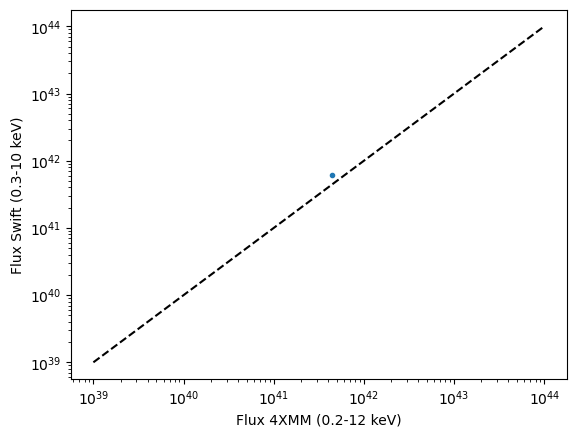

In [8]:
fluxes_4xmm = catalog["4XMM Mean Flux (0.2-12keV band)"]
fluxes_4xmm_err = catalog["4XMM Mean Flux Error (0.2-12keV band)"]
fluxes_swift = catalog["Swift PowerLaw-Flux"]
fluxes_swift_err = 0.5 * (catalog["Swift Flux Neg"] + catalog["Swift Flux Pos"])

fig, ax = plt.subplots()
ax.errorbar(
    fluxes_4xmm[fermi_sources],
    fluxes_swift[fermi_sources],
    xerr=fluxes_4xmm_err[fermi_sources],
    yerr=fluxes_swift_err[fermi_sources],
    ls="",
    marker="."
)
# let us add a striaght line to check
# if there is linear correlation
x = np.logspace(39, 44)
ax.plot(x, x, ls="--", color="k")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Flux 4XMM (0.2-12 keV)")
ax.set_ylabel("Flux Swift (0.3-10 keV)")
plt.show()

In [9]:
non_null_4xmm = fluxes_4xmm > 0
non_null_swift = fluxes_swift > 0

swift_4xmm_detection_mask = non_null_4xmm * non_null_swift

In [10]:
# which are the sources for which we have both 4XMM and Swift data?
print(catalog["SOURCE_NAME"][non_null_4xmm * non_null_swift])
print(catalog["SOURCE_TYPE"][non_null_4xmm * non_null_swift])
print(catalog["SIMBAD FERMI-ID"][non_null_4xmm * non_null_swift])

SOURCE_NAME
-----------
    IC 4587
     NGC315
    NGC3226
    NGC4374
SOURCE_TYPE
-----------
        FR0
       L1.9
       L1.9
         L2
 SIMBAD FERMI-ID 
-----------------
               --
4FGL J0057.7+3023
               --
               --


## Hardness ratio vs radio luminosity

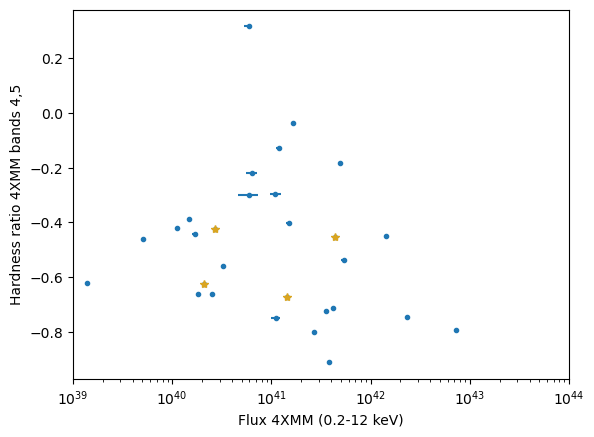

In [11]:
hardness_ratio = catalog["Hardness Ratio 4-5"]

fig, ax = plt.subplots()
ax.errorbar(
    fluxes_4xmm[non_null_4xmm],
    hardness_ratio[non_null_4xmm],
    xerr=fluxes_4xmm_err[non_null_4xmm],
    #yerr=fluxes_swift_err,
    ls="",
    marker="."
)
#ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Flux 4XMM (0.2-12 keV)")
ax.set_ylabel("Hardness ratio 4XMM bands 4,5")

# add sources in both catalogues
ax.errorbar(
    fluxes_4xmm[swift_4xmm_detection_mask],
    hardness_ratio[swift_4xmm_detection_mask],
    xerr=fluxes_4xmm_err[swift_4xmm_detection_mask],
    #yerr=fluxes_swift_err,
    ls="",
    marker="*",
    color="goldenrod"
)
ax.set_xlim([1e39, 1e44])
plt.show()

In [12]:
hard_sources = hardness_ratio > 0
print(catalog["SOURCE_NAME"][hard_sources])
print(catalog["SIMBAD SDSS-ID"][hard_sources])
print(catalog["SOURCE_TYPE"][hard_sources])
print(fluxes_4xmm[hard_sources])

SOURCE_NAME
-----------
         --
     SIMBAD SDSS-ID     
------------------------
SDSS J101806.67+000559.7
SOURCE_TYPE
-----------
        FR0
4XMM Mean Flux (0.2-12keV band)
            erg / s            
-------------------------------
          5.880308286982916e+40


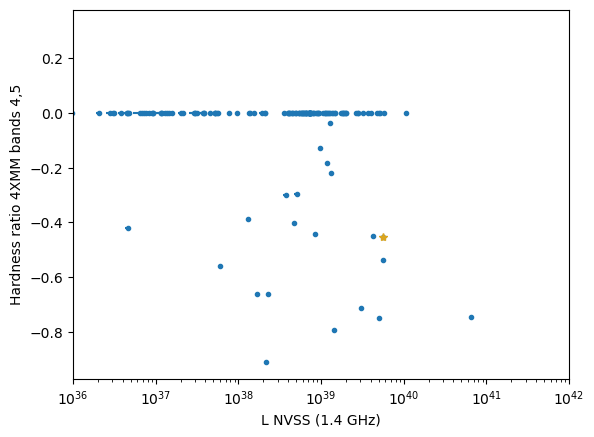

In [13]:
L_nvss = catalog["NVSS-FLUX-XMATCH"]
L_nvss_err = catalog["NVSS-FLUX-ERROR-XMATCH"]

fig, ax = plt.subplots()
ax.errorbar(
    L_nvss,
    hardness_ratio,
    xerr=L_nvss_err,
    #yerr=fluxes_swift_err,
    ls="",
    marker="."
)
#ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("L NVSS (1.4 GHz)")
ax.set_ylabel("Hardness ratio 4XMM bands 4,5")

# add sources in both catalogues
ax.errorbar(
    L_nvss[swift_4xmm_detection_mask],
    hardness_ratio[swift_4xmm_detection_mask],
    xerr=L_nvss_err[swift_4xmm_detection_mask],
    #yerr=fluxes_swift_err,
    ls="",
    marker="*",
    color="goldenrod"
)
ax.set_xlim([1e36, 1e42])
plt.show()

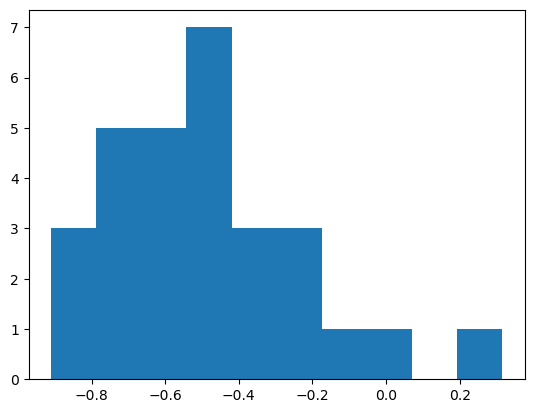

In [14]:
non_zero_hr = hardness_ratio != 0
plt.hist(hardness_ratio[non_zero_hr])
plt.show()

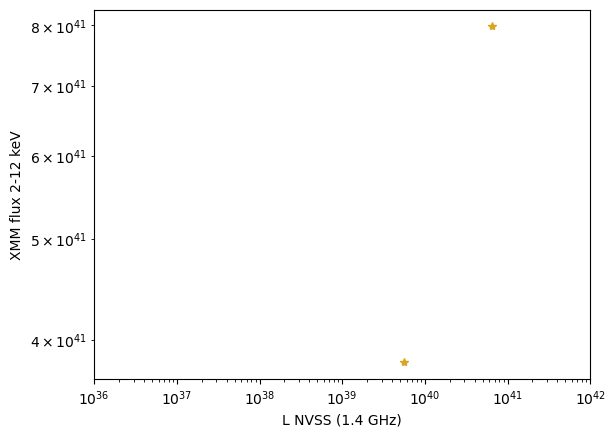

In [15]:
fig, ax = plt.subplots()

ax.errorbar(
    L_nvss[fermi_sources],
    fluxes_4xmm_nontherm[fermi_sources],
    xerr=L_nvss_err[fermi_sources],
    #yerr=fluxes_swift_err,
    ls="",
    marker="*",
    color="goldenrod"
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("L NVSS (1.4 GHz)")
ax.set_ylabel("XMM flux 2-12 keV")
ax.set_xlim([1e36, 1e42])
plt.show()

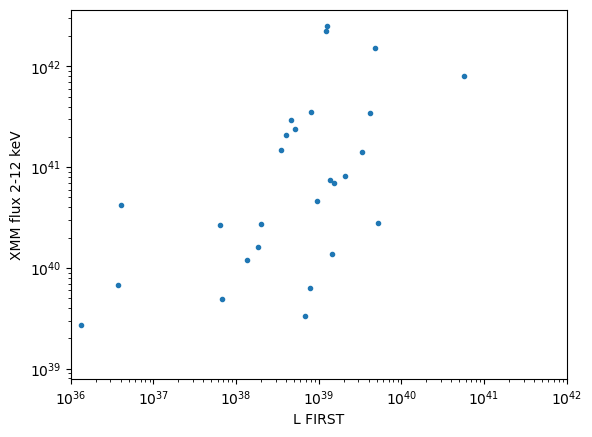

In [16]:
first_flux = catalog["FIRST-FLUX-XMATCH"]
first_flux_err = catalog["FIRST-FLUX-ERROR-XMATCH"]
fig, ax = plt.subplots()
ax.errorbar(
    first_flux,
    fluxes_4xmm_nontherm,
    xerr=first_flux_err,
    #yerr=fluxes_swift_err,
    ls="",
    marker="."
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("L FIRST")
ax.set_ylabel("XMM flux 2-12 keV")
ax.set_xlim([1e36, 1e42])
plt.show()

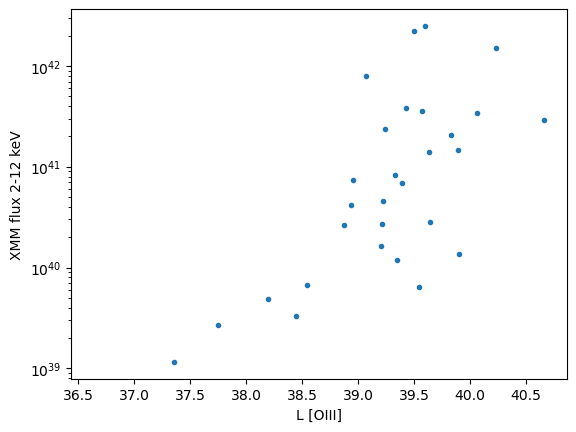

In [17]:
OIII = catalog["Log10(L_OIII)"]
first_flux_err = catalog["FIRST-FLUX-ERROR-XMATCH"]
fig, ax = plt.subplots()
ax.errorbar(
    OIII,
    fluxes_4xmm_nontherm,
    #xerr=first_flux_err,
    #yerr=fluxes_swift_err,
    ls="",
    marker="."
)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("L [OIII]")
ax.set_ylabel("XMM flux 2-12 keV")
#ax.set_xlim([1e36, 1e42])
plt.show()

In [18]:
path = Path("./")
path.mkdir(exist_ok=True, parents=True)
catalog.write(
    path / "modified_catalogue.fits", overwrite=True
)